# Gaussian Process and Machine Learning

In [1]:
using ColorSchemes
using CSV
using DataFrames
using Dates
using Optim
using Plots
using Printf
using Statistics
using LaTeXStrings
using LinearAlgebra

In [2]:
include("gp.jl")

fg! (generic function with 1 method)

## Sampling from 1D Gaussian Process

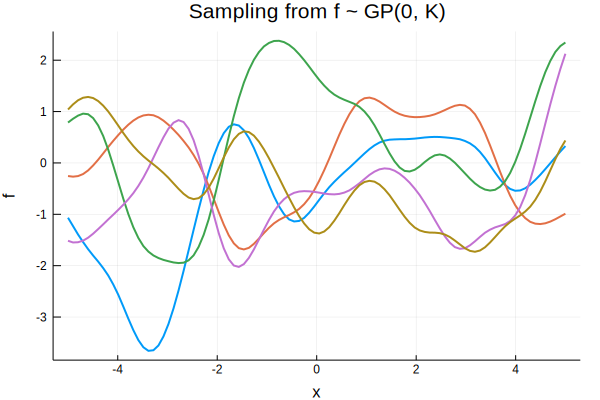

In [3]:
xs = collect(range(-5, stop = 5, length = 100))

gp = GaussianProcess(GaussianKernel(1))
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "Sampling from f ~ GP(0, K)")

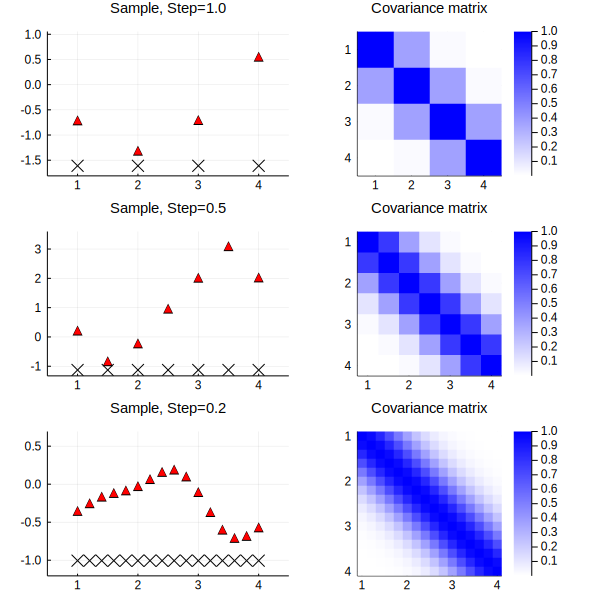

In [4]:
xx = [1:4, 1:0.5:4, 1:0.2:4]
yy = [1, 0.5, 0.2]

plts = []
for (x, y) in zip(xx, yy)
    x1 = collect(x)
    n = Base.length(x)
    sample = rand(dist(gp, x1))
    sample_min = minimum(sample)
    sample_plot = scatter(x, sample, label = "",
            markershape = :utriangle, markercolor = :red,
            title = @sprintf("Sample, Step=%.1f", y), titlefontsize = 10)
    scatter!(x, fill(sample_min - 0.3, n),
        xlims = (0.5, 4.5),
        ylims = (sample_min - 0.5, maximum(sample) + 0.5),
        markershape = :x, markerstrokewidth = 2,
        label = "")
    push!(plts, sample_plot)
    push!(plts, heatmap(x1, x1, cov(gp, x1), 
            title = "Covariance matrix", titlefontsize = 10,
            aspect_ratio = :equal, yflip = true, color = cgrad([:white, :blue])))
end

Plots.plot(plts..., layout = (3, 2), size = [600, 600])

## Sampling from 2D Gaussian Process

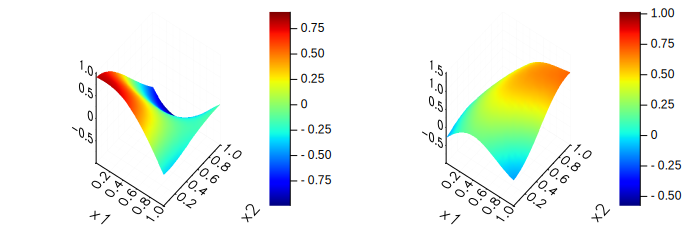

In [5]:
x1, x2 = 0:0.05:1, 0:0.05:1
n1, n2 = Base.length(x1), Base.length(x2)
n = n1 * n2
pt = permutedims(hcat([[i, j] for i in x1, j in x2]...));
sample = rand(dist(gp, pt), 2)

plts = []
for i in 1:2
    z = reshape(sample[:, i], n1, n2)
    push!(plts,
        surface(x1, x2, z, alpha = 0.8, camera = (40, 60),
        seriescolor = cgrad(ColorSchemes.jet1.colors), 
        linewidth = 2,
        framestyle = :grid,
        xlabel = "x1", ylabel = "x2", zlabel = "f"))
end
Plots.plot(plts..., layout = (1, 2), size = [700, 250])

## Kernel Types (Linear, Gaussian, Exponential, Periodic)

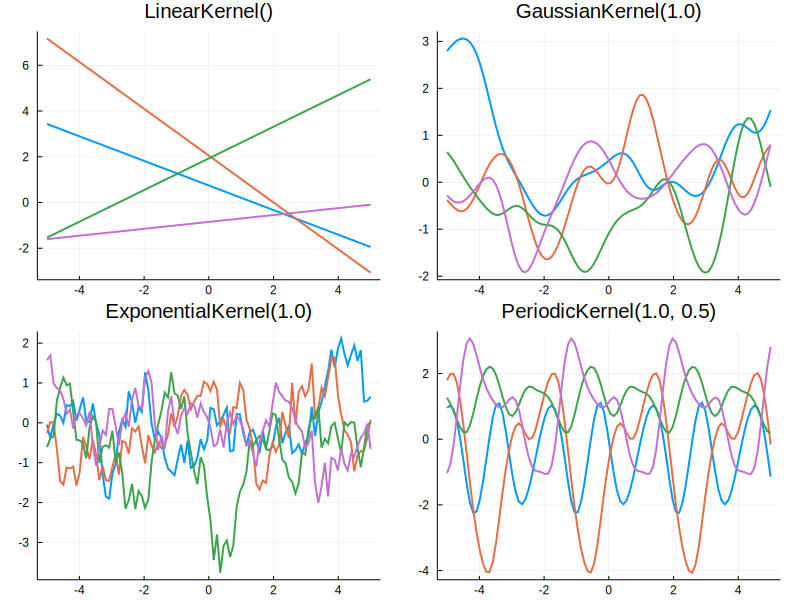

In [6]:
xs = collect(range(-5, stop = 5, length = 100))
kernels = [LinearKernel(), GaussianKernel(1),
           ExponentialKernel(1), PeriodicKernel(1.0, 0.5)]
plts = []

for k in kernels
    gp = GaussianProcess(k)
    p = Plots.plot(xs, rand(dist(gp, xs), 4), label = "", linewidth = 2, title = @sprintf("%s", k))
    push!(plts, p)
end
    
Plots.plot(plts..., layout = (2, 2), size = [800, 600])

## Linear combination

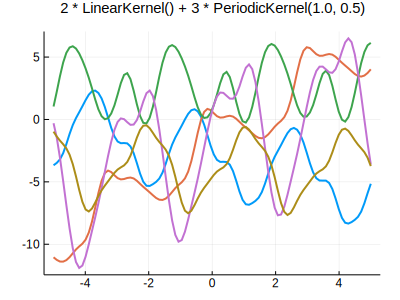

In [7]:
xs = collect(range(-5, stop = 5, length = 100))
l_ker = 2.0 * LinearKernel() + 3.0 * PeriodicKernel(1.0, 0.5)

gp = GaussianProcess(l_ker)
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", size = [400, 300],
    linewidth = 2,
    title = "2 * LinearKernel() + 3 * PeriodicKernel(1.0, 0.5)", titlefontsize = 10)

## Matérn kernel

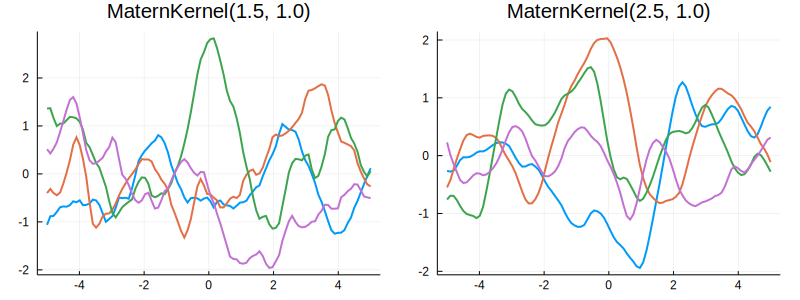

In [8]:
xs = collect(range(-5, stop = 5, length = 100))
kernels = [MaternKernel(3/2, 1.), MaternKernel(5/2, 1.)]
plts = []

for k in kernels
    gp = GaussianProcess(k)
    p = Plots.plot(xs, rand(dist(gp, xs), 4), label = "", linewidth = 2, title = @sprintf("%s", k))
    push!(plts, p)
end
    
Plots.plot(plts..., layout = (1, 2), size = [800, 300])

## Gaussian Process Regression

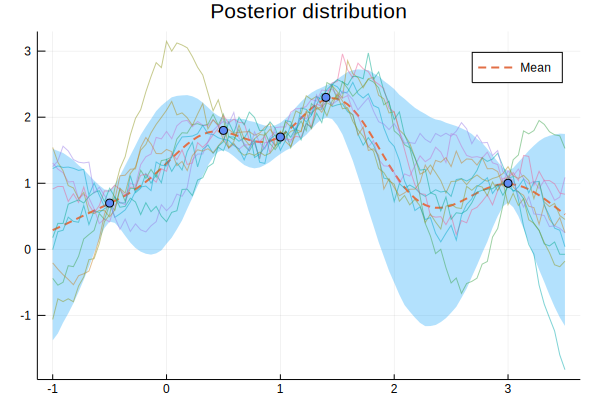

In [9]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]
gp = GaussianProcess(GaussianKernel(0.4), 0.01)
xtrain = collect(range(-1, stop=3.5, length=100))
pred = predict(gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.925]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)
Plots.plot!(xtrain, rand(pred, 10), label = "", linewidth = 1, linealpha = 0.5)

scatter!(xs, ys, label = "", title = "Posterior distribution")

## Hyperparameter optimization

In [10]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]

gp1 = GaussianProcess(KernelProduct(GaussianKernel(1)), 1)

GaussianProcess(GPKernel{KernelProduct}(KernelProduct(1.0, GaussianKernel[GaussianKernel(1.0)]), 1.0), GPStandard())

In [11]:
# optimization with gradient, GradientDescent
# we minimize -logp instead of maximize logp

lower = fill(-30.0, 3)
upper = fill(30.0, 3)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp1, xs, ys, F, G, x)),
    lower, upper, [0.0, 0.0, 0.0], 
    Fminbox(GradientDescent()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))

Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.46777285165203614,1.881036295396796, ...]
 * Minimum: 1.738770e+00
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.76e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 229
 * Gradient Calls: 229
[theta1, theta2, theta3] = [1.59643, 6.5603, 0.0819847]


In [12]:
# optimization with gradient, L-BFGS
lower = fill(-30.0, 3)
upper = fill(30.0, 3)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp1, xs, ys, F, G, x)),
    lower, upper, [0.0, 0.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.4677728191930469,1.881036276191538, ...]
 * Minimum: 1.738770e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 6.02e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 151
 * Gradient Calls: 151
[theta1, theta2, theta3] = [1.59643, 6.5603, 0.0819847]


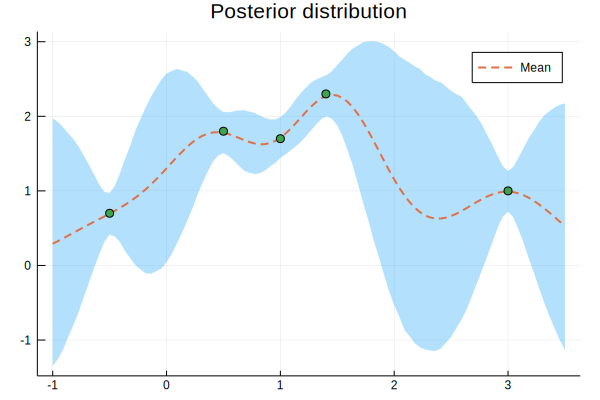

In [13]:
update!(gp1, exp.(pars)...)
xtest = collect(range(-1, stop=3.5, length=100))
pred = predict(gp, xtest, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtest, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtest, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

In [14]:
gp1

GaussianProcess(GPKernel{KernelProduct}(KernelProduct(1.5964346821676998, GaussianKernel[GaussianKernel(6.5603)]), 0.08198471428962331), GPStandard())

In [15]:
# log likelihood
logp(gp1, xs, ys)

-1.7387703743398144

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.4216679657057178,-0.3720994324869738, ...]
 * Minimum: 2.509299e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 7.18e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 139
 * Gradient Calls: 139
[theta1, theta2, theta3] = [1.5245, 0.689286, 0.0670132]


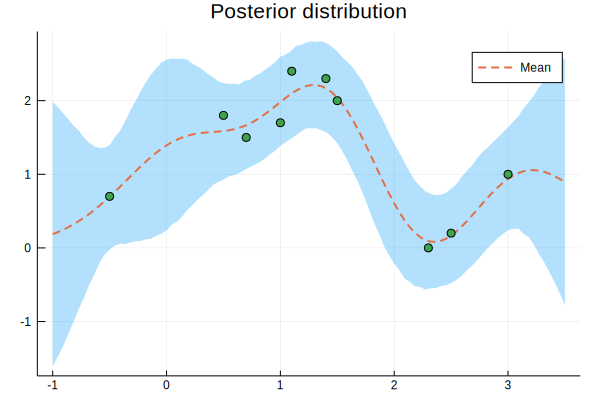

In [16]:
# Add more points

xs = [-0.5, 0.5, 1, 1.4, 3, 2.3, 2.5, 1.5, 1.1, 0.7]
ys = [0.7, 1.8, 1.7, 2.3, 1, 0, 0.2, 2, 2.4, 1.5]

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp1, xs, ys, F, G, x)),
    lower, upper, [0.0, 0.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))

update!(gp1, exp.(pars)...)
xtest = collect(range(-1, stop=3.5, length=100))
pred = predict(gp1, xtest, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtest, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtest, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

In [17]:
# log likelihood
logp(gp1, xs, ys)

-2.5092991676862004

## Local solutions

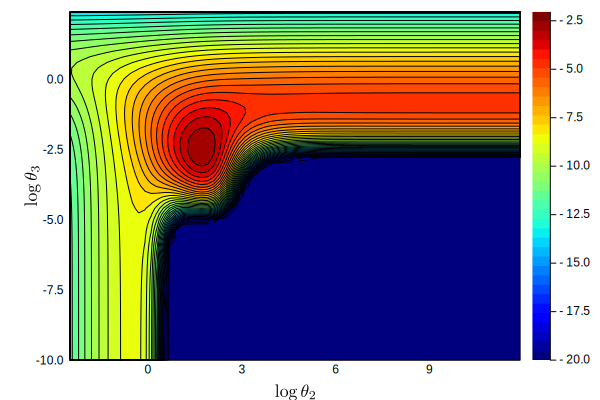

In [18]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]

function f_logp(x, y)
    update!(gp1, exp.([0, x, y])...)
    max(-20, logp(gp1, xs, ys)) # set floor of logp to be -20
end

theta2, theta3 = -2.5:0.2:12, -10:0.2:2.5
z = Surface((x, y) -> f_logp(x, y), theta2, theta3)
contourf(theta2, theta3, z, seriescolor = cgrad(ColorSchemes.jet1.colors), 
    levels = collect(-20:0.5:-2),
    xlabel = L"\log \theta_2", ylabel = L"\log \theta_3",
    guidefont=font(12))

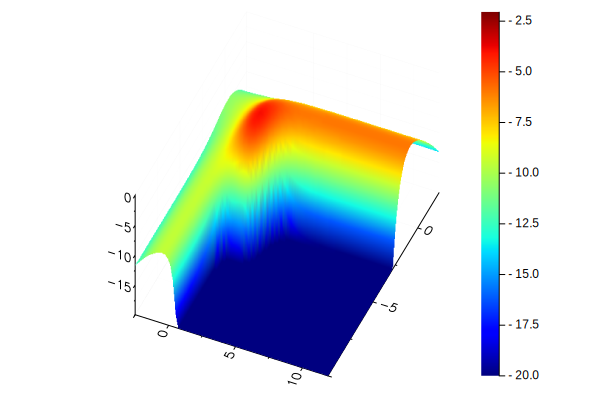

In [19]:
surface(theta2, theta3, z, seriescolor = cgrad(ColorSchemes.jet1.colors), camera = (30, 70))

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0]
 * Minimizer: [1.728624050806402,-2.483194016964428]
 * Minimum: 2.029922e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 4.29e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 2.19e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.06e-10 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 93
 * Gradient Calls: 93
logp:-2.0299222400060897


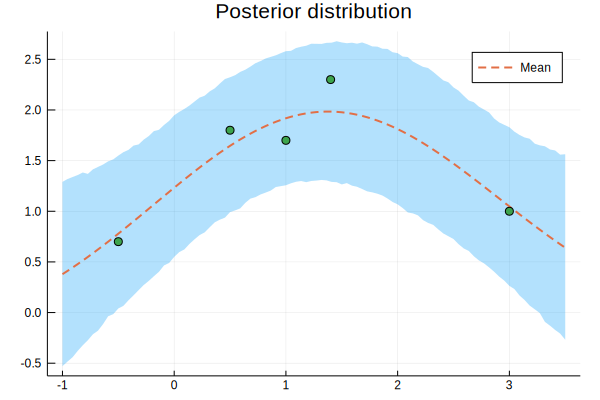

In [20]:
lower = fill(-30.0, 2)
upper = fill(30.0, 2)

n_xs = size(xs, 1)

function fg_2!(gp::GaussianProcess, F, G, x)
    update!(gp, exp.([0, x...])...)
    k = cov(gp, xs)
    k_inv = inv(k)
    k_inv_y = k_inv * ys

    n = size(xs, 1)

    function deriv(d_mat::Matrix{<: Real})
        -(-tr(k_inv * d_mat) + k_inv_y' * d_mat * k_inv_y)
    end
    
    distance_matrix = zeros(n_xs, n_xs)
    for i in 1:n_xs
        for j in 1:n_xs
            distance_matrix[i, j] = (xs[i] - xs[j]).^2
        end
    end
    
    if G!= nothing
        y = exp.(x)
        d_tau = k - y[2] .* Matrix{Float64}(I, n_xs, n_xs)
        d_sigma = d_tau ./ y[1] .* distance_matrix
        d_eta = y[2] .* Matrix{Float64}(I, n_xs, n_xs)
        G[1] = deriv(d_sigma)
        G[2] = deriv(d_eta)
    end
    
    if F!= nothing
        value = -(-log(det(k)) - ys' * k_inv * ys)
        return value
    end

end

# starting from (0, 0)
res = optimize(
    Optim.only_fg!((F, G, x) -> fg_2!(gp1, F, G, x)),
    lower, upper, [0.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("logp:", logp(gp1, xs, ys))

update!(gp1, exp.([0, pars...])...)
xtest = collect(range(-1, stop=3.5, length=100))
pred = predict(gp1, xtest, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtest, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtest, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [5.0,0.0]
 * Minimizer: [22.275332447363116,-0.8582661631595884]
 * Minimum: 4.247956e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 6.13e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.92e-07 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.80e-09 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 192
 * Gradient Calls: 192
logp:-4.2479555263562085


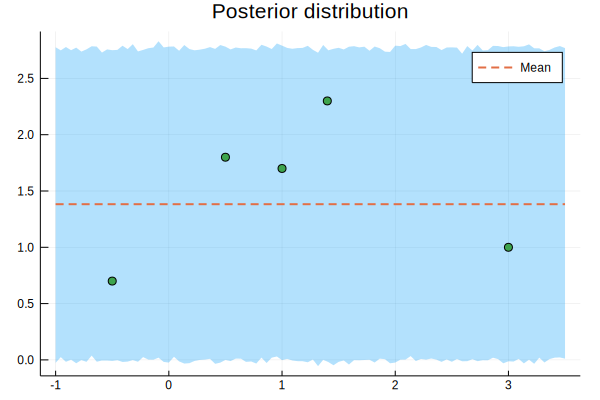

In [21]:
# starting from (5, 0)
res = optimize(
    Optim.only_fg!((F, G, x) -> fg_2!(gp1, F, G, x)),
    lower, upper, [5.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("logp:", logp(gp1, xs, ys))

update!(gp1, exp.([0, pars...])...)
xtest = collect(range(-1, stop=3.5, length=100))
pred = predict(gp1, xtest, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtest, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtest, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

## Selection of kernels
### Gaussian Kernel

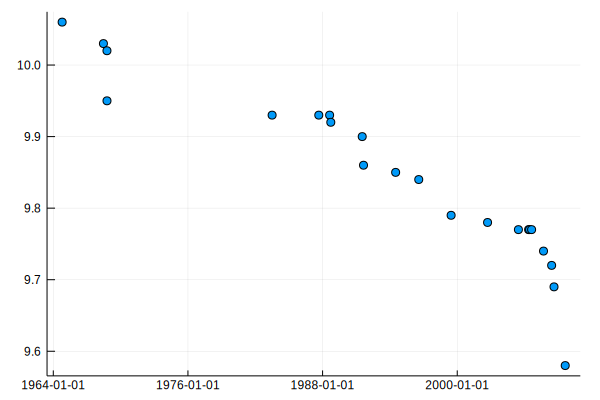

In [22]:
record_100m = CSV.read("data/100m.csv"; dateformat="yyyy/mm/dd")
disallowmissing!(record_100m)
scatter(record_100m.Date, record_100m.Time, label="")

In [23]:
xs_raw = Dates.value.(record_100m.Date .- Date(0, 1, 1)) ./ 365
xs_mean, xs_std = mean(xs_raw), std(xs_raw)
ys_raw = record_100m.Time
ys_mean, ys_std = mean(ys_raw), std(ys_raw)

(9.845454545454546, 0.12018744379102851)

In [24]:
function plot_gp_100m(gp, pars)

    update!(gp, exp.(pars)...)
    x_test = collect(range(-2, stop=2, length=100))
    pred = predict(gp, x_test, xs, ys)
    qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

    # convert
    x_test = x_test .* xs_std .+ xs_mean
    qt = qt .* ys_std .+ ys_mean
    Plots.plot(x_test, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
        label = "", linewidth = 0)
    Plots.plot!(x_test, mean(pred) .* ys_std .+ ys_mean, label = "", linewidth = 2, linestyle = :dash)
    scatter!(xs_raw, ys_raw, label = "")
end

plot_gp_100m (generic function with 1 method)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [1.4404902525796488,2.6294996100889922, ...]
 * Minimum: -1.486413e+01
 * Iterations: 38
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.60e-07 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 16933
 * Gradient Calls: 16933
[theta1, theta2, theta3] = [4.22277, 13.8668, 0.102625]
logp:14.864131619223823


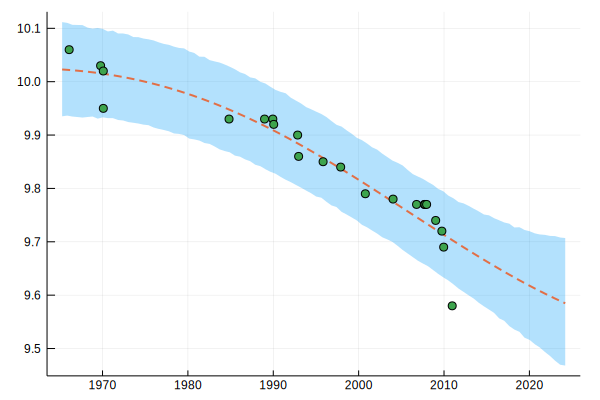

In [25]:
# start from [0.0, 0.0, 0.0]
xs = (xs_raw .- xs_mean) ./ xs_std
ys = (ys_raw .- ys_mean) ./ ys_std

gp_100m = GaussianProcess(1 * GaussianKernel(1), 1)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp_100m, xs, ys, F, G, x)),
    fill(-10.0, 3), fill(10.0, 3), [0.0, 0.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))
println("logp:", logp(gp_100m, xs, ys))

plot_gp_100m(gp_100m, pars)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,-3.0]
 * Minimizer: [0.4403584986004196,-1.4741097524020803, ...]
 * Minimum: -1.407396e+01
 * Iterations: 5
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 9.41e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 300
 * Gradient Calls: 300
[theta1, theta2, theta3] = [1.55326, 0.228982, 0.0429989]
logp:14.073964533876048


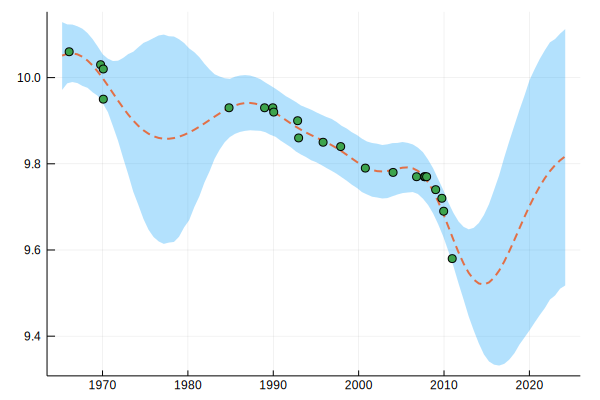

In [26]:
# start from [0.0, 0.0, -3.0]

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp_100m, xs, ys, F, G, x)),
    fill(-10.0, 3), fill(10.0, 3), [0.0, 0.0, -3.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))
println("logp:", logp(gp_100m, xs, ys))

plot_gp_100m(gp_100m, pars)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0,0.0,-3.0]
 * Minimizer: [-2.9461204292686456,-0.704947075402076, ...]
 * Minimum: -1.966736e+01
 * Iterations: 12
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 4.34e-01 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 5156
 * Gradient Calls: 5156
[theta1, theta2, theta3, theta4, theta5] = [0.0525432, 0.494135, 0.109475, 0.0256015, 0.046597]
logp:14.073964533876048


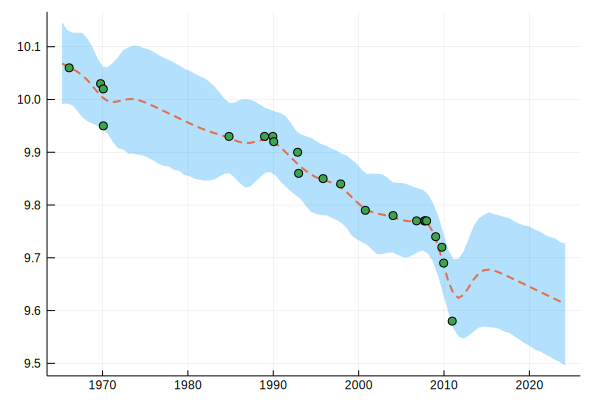

In [27]:
gp_100m_2 = GaussianProcess(ConstantKernel() + LinearKernel() + GaussianKernel(1), 1)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp_100m_2, xs, ys, F, G, x)),
    fill(-10.0, 5), fill(10.0, 5), [0.0, 0.0, 0.0, 0.0, -3.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3, theta4, theta5] = ", exp.(pars))
println("logp:", logp(gp_100m, xs, ys))

plot_gp_100m(gp_100m_2, pars)

## Inducing variable method

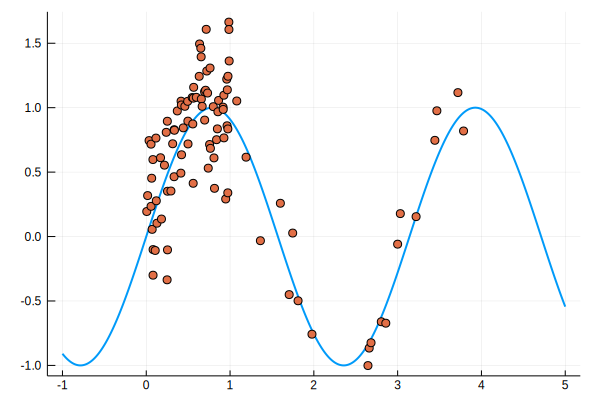

In [93]:
xs = vcat(rand(80),rand(20) * 3 .+ 1.0)
sort!(xs)
fx = sin.(xs*2)
ys = fx + rand(Normal(), Base.length(fx)) * 0.3

ts = collect(-1:0.01:5)
plot(ts, sin.(ts*2), lw = 2, label = "")
scatter!(xs, ys, label = "")

In [94]:
gk = GaussianKernel(2)
gp = GaussianProcess(gk)

GaussianProcess(GPKernel{GaussianKernel}(GaussianKernel(2.0), 1.0e-6), GPStandard())

### Standard method (for reference)

In [97]:
dist_gp = predict(gp, ts, xs, ys)

FullNormal(
dim: 601
μ: [46.1415, 45.2712, 44.4029, 43.5369, 42.6736, 41.8134, 40.9567, 40.1038, 39.255, 38.4107  …  -29.2434, -29.6926, -30.14, -30.5853, -31.0284, -31.469, -31.907, -32.3422, -32.7743, -33.2031]
Σ: [0.0336403 0.0327767 … 0.00200857 0.00201661; 0.0327767 0.0319384 … 0.00198186 0.00198995; … ; 0.00200857 0.00198186 … 0.126145 0.128388; 0.00201661 0.00198995 … 0.128388 0.130678]
)


In [104]:
dist_gp.μ

601-element Array{Float64,1}:
  46.14148949380281 
  45.27119340861721 
  44.40286645820972 
  43.53688514825891 
  42.67362151970027 
  41.813442858940675
  40.956711418891665
  40.10378413975968 
  39.25501238663976 
  38.41074167396173 
  37.57131142647613 
  36.737054713277885
  35.90829801974948 
   ⋮                
 -28.340376236817868
 -28.792599471747167
 -29.24340840782562 
 -29.692597437264133
 -30.139960781207115
 -30.585292654292395
 -31.028387429010927
 -31.469039800048503
 -31.90704494830658 
 -32.342198705230174
 -32.77429771591782 
 -33.203139601773145

In [106]:
Matrix(dist_gp.Σ)

601×601 Array{Float64,2}:
 0.0336403   0.0327767   0.0319251   …  0.00199992  0.00200857  0.00201661
 0.0327767   0.0319384   0.0311087      0.00197318  0.00198186  0.00198995
 0.0319251   0.0311087   0.0303036      0.00194601  0.00195472  0.00196285
 0.0310845   0.0302908   0.029507       0.00191843  0.00192717  0.00193533
 0.0302553   0.0294838   0.0287219      0.00189047  0.00189922  0.00190741
 0.0294375   0.0286879   0.0279476   …  0.00186215  0.0018709   0.0018791 
 0.0286313   0.0279033   0.0271842      0.00183348  0.00184224  0.00185045
 0.0278369   0.0271301   0.0264319      0.0018045   0.00181324  0.00182145
 0.0270544   0.0263684   0.0256908      0.00177521  0.00178394  0.00179215
 0.0262839   0.0256184   0.024961       0.00174565  0.00175436  0.00176256
 0.0255256   0.0248802   0.0242427   …  0.00171584  0.00172452  0.0017327 
 0.0247796   0.0241539   0.0235358      0.0016858   0.00169445  0.0017026 
 0.0240459   0.0234396   0.0228407      0.00165555  0.00166416  0.00167228

### IPV

In [108]:
zs = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

9-element Array{Float64,1}:
 0.0
 0.5
 1.0
 1.5
 2.0
 2.5
 3.0
 3.5
 4.0

In [109]:
K_xx = cov(gk, xs, xs)

100×100 Array{Float64,2}:
 1.0          0.999945     …  0.00249527  0.00101347  0.000787258
 0.999945     1.0             0.0025874   0.00105366  0.000819056
 0.999612     0.999849        0.00274699  0.00112354  0.000874403
 0.998698     0.999178        0.00297374  0.00122339  0.000953594
 0.998673     0.999158        0.00297873  0.00122559  0.000955343
 0.99828      0.998839     …  0.00305215  0.00125806  0.000981123
 0.997917     0.998538        0.00311399  0.00128545  0.00100288 
 0.997295     0.99801         0.00321084  0.00132844  0.00103705 
 0.997185     0.997916        0.00322692  0.00133558  0.00104274 
 0.997143     0.997879        0.00323314  0.00133835  0.00104494 
 0.99492      0.995919     …  0.00352094  0.00146676  0.00114715 
 0.993996     0.995086        0.00362676  0.0015142   0.00118495 
 0.993534     0.994667        0.00367759  0.00153702  0.00120315 
 ⋮                         ⋱                                     
 0.030676     0.0315354       0.713084    0.562018

In [110]:
K_xz = cov(gk, xs, zs)

100×9 Array{Float64,2}:
 0.999982     0.885109    0.610138   …  0.0113088  0.00223346  0.000343533
 0.999865     0.889659    0.616498      0.0116689  0.0023167   0.000358209
 0.999428     0.897033    0.627035      0.0122882  0.00246095  0.000383835
 0.998377     0.906533    0.64106       0.013159   0.00266606  0.000420672
 0.998349     0.90673     0.641357      0.013178   0.00267057  0.000421488
 0.997914     0.909579    0.645675   …  0.0134578  0.00273703  0.000433522
 0.997516     0.911902    0.649236      0.0136926  0.002793    0.000443695
 0.99684      0.915407    0.65468       0.0140589  0.00288071  0.000459697
 0.996722     0.915973    0.655568      0.0141196  0.00289526  0.000462361
 0.996676     0.916192    0.655911      0.014143   0.0029009   0.000463393
 0.994305     0.925636    0.671099   …  0.0152208  0.00316167  0.000511471
 0.99333      0.928815    0.676381      0.0156136  0.00325761  0.000529321
 0.992844     0.930291    0.678865      0.0158017  0.0033037   0.000537927
 

In [111]:
K_zz = cov(gk, zs, zs)

9×9 Array{Float64,2}:
 1.0          0.882497    0.606531   …  0.011109   0.00218749  0.000335463
 0.882497     1.0         0.882497      0.0439369  0.011109    0.00218749 
 0.606531     0.882497    1.0           0.135335   0.0439369   0.011109   
 0.324652     0.606531    0.882497      0.324652   0.135335    0.0439369  
 0.135335     0.324652    0.606531      0.606531   0.324652    0.135335   
 0.0439369    0.135335    0.324652   …  0.882497   0.606531    0.324652   
 0.011109     0.0439369   0.135335      1.0        0.882497    0.606531   
 0.00218749   0.011109    0.0439369     0.882497   1.0         0.882497   
 0.000335463  0.00218749  0.011109      0.606531   0.882497    1.0        

In [68]:
inv_K_zz = inv(K_zz)

9×9 Array{Float64,2}:
   85.1634   -292.611    539.896  …    321.566   -134.593    30.2743
 -292.611    1079.78   -2099.78      -1395.48     592.088  -134.593 
  539.896   -2099.78    4289.75       3232.65   -1395.48    321.566 
 -698.33     2824.96   -6018.66      -5207.61    2297.73   -538.863 
  692.386   -2885.73    6362.74       6362.74   -2885.73    692.386 
 -538.863    2297.73   -5207.61   …  -6018.66    2824.96   -698.33  
  321.566   -1395.48    3232.65       4289.75   -2099.78    539.896 
 -134.593     592.088  -1395.48      -2099.78    1079.78   -292.611 
   30.2743   -134.593    321.566       539.896   -292.611    85.1634

In [69]:
function lambda(x, k)
    # println(ker(gk, x, x), k' * inv_K_zz * k)
    ker(gk, x, x) - k' * inv_K_zz * k
end

lambda (generic function with 1 method)

In [70]:
for i in 1:n
     lambda(xs[i, :], K_xz[i, :])
end

In [42]:
[lambda(xs[i, :], K_xz[i, :]) for i in 1:n]

100-element Array{Float64,1}:
 0.07096157421975025 
 0.07025718365376499 
 0.06627014182848168 
 0.06550214864378523 
 0.06342228840974795 
 0.06339690466276193 
 0.06228185547983356 
 0.05955653656426785 
 0.05844426683220871 
 0.05709595457399963 
 0.05396838101092316 
 0.05268007201701763 
 0.05114849223281259 
 ⋮                   
 0.043264211314186785
 0.043265918401609205
 0.04327036805566531 
 0.04374313807548247 
 0.044164273469710635
 0.044465344737926404
 0.045095565454461806
 0.04492986902430096 
 0.04483552554158532 
 0.04570930068948398 
 0.05107609821183434 
 0.052248150515630476

In [43]:
L = Diagonal([lambda(xs[i, :], K_xz[i, :]) + eta^2 for i in 1:n])

100×100 Diagonal{Float64,Array{Float64,1}}:
 0.0809616   ⋅          ⋅         …   ⋅          ⋅          ⋅       
  ⋅         0.0802572   ⋅             ⋅          ⋅          ⋅       
  ⋅          ⋅         0.0762701      ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅       
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅       
 ⋮                                ⋱                        

In [44]:
K_xx + eta^2 * Matrix{Float64}(I, n, n)

100×100 Array{Float64,2}:
 1.01         0.99999      0.9995       …  0.000731727  0.000681231
 0.99999      1.01         0.999632        0.000744296  0.000692991
 0.9995       0.999632     1.01            0.000824768  0.000768308
 0.999306     0.999463     0.999984        0.000842415  0.000784829
 0.998584     0.998812     0.999767        0.000894538  0.00083364 
 0.998573     0.998802     0.999762     …  0.000895218  0.000834276
 0.998046     0.998316     0.999522        0.000926216  0.000863312
 0.996256     0.996633     0.99849         0.00101312   0.000944742
 0.995274     0.995699     0.997844        0.0010542    0.000983248
 0.993839     0.994324     0.996841        0.00110955   0.00103514 
 0.989113     0.98976      0.993256     …  0.00126994   0.00118559 
 0.986365     0.987089     0.991053        0.00135471   0.00126515 
 0.982179     0.983005     0.987594        0.00147744   0.00138039 
 ⋮                                      ⋱                          
 0.0461716    0.046687

In [45]:
Q_mm = K_mm + K_nm' * inv(L) *  K_nm

UndefVarError: UndefVarError: K_nm not defined

In [46]:
inv(Q_mm)

UndefVarError: UndefVarError: Q_mm not defined

In [47]:
K_nm * K_nm'

UndefVarError: UndefVarError: K_nm not defined

In [48]:
K_nm * inv(Q_mm) * K_nm'

UndefVarError: UndefVarError: Q_mm not defined

In [50]:

function lambda(x, k)
     ker(gk, x, x) - k' * inv(K_mm) * k
end

Λ = Diagonal([lambda(xs[i, :], K_nm[i, :]) for i in 1:n])

K_nm_Λ_σ2= K_nm' * inv(Λ + eta^2 * Matrix{Float64}(I, n, n))
Q_mm = K_mm + K_nm_Λ_σ2 * K_nm
K_mm_Q_mm = K_mm * inv(Q_mm)
u = K_mm_Q_mm * K_nm_Λ_σ2 * ys
Σ_u = K_mm_Q_mm * K_mm

xxs = collect(-1:0.01:5)
m = size(xxs, 1)
k_starstar = cov(gk, xxs, xxs)
k_mstar = cov(gk, ind_xs, xxs)
f_star = k_mstar' * inv(K_mm) * u
σ_fstar = (k_starstar - k_mstar' * inv(Σ_u) * k_mstar) + eta^2 * Matrix{Float64}(I, m, m)

dist = MvNormal(f_star, Symmetric(σ_fstar))

PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [84]:
k_mstar

10×601 Array{Float64,2}:
 0.367879     0.375274     0.38274      …  1.5347e-11   1.38879e-11
 0.105399     0.108598     0.111872        1.75622e-9   1.60523e-9 
 0.0183156    0.0190612    0.0198332       1.21896e-7   1.12535e-7 
 0.00193045   0.00202923   0.00213263      5.13156e-6   4.78512e-6 
 0.00012341   0.000131028  0.000139089     0.000131028  0.00012341 
 4.78512e-6   5.13156e-6   5.50199e-6   …  0.00202923   0.00193045 
 1.12535e-7   1.21896e-7   1.32008e-7      0.0190612    0.0183156  
 1.60523e-9   1.75622e-9   1.92104e-9      0.108598     0.105399   
 1.38879e-11  1.5347e-11   1.6956e-11      0.375274     0.367879   
 7.28772e-14  8.13431e-14  9.07743e-14     0.786549     0.778801   

In [83]:
eigvals(Symmetric(σ_fstar))

601-element Array{Float64,1}:
 -9680.278388068962     
 -1551.421972160897     
  -906.6056779697436    
  -278.95648265200396   
   -60.94777198963065   
    -7.810862932716668  
    -0.18472459157233395
     0.9355674698584586 
     0.9974800452978072 
     0.9999605658515623 
     0.9999999999941344 
     0.9999999999973364 
     0.9999999999980018 
     ⋮                  
     1.0000002102053465 
     1.0000010197619176 
     1.0000047345831211 
     1.0000210553455366 
     1.0000909443231745 
     1.0003804016786864 
     1.0016803399149865 
     1.0097169408598445 
     1.017485415927801  
     1.2676317845090035 
     2.662405401090412  
    12.230104677368557  